# Init

In [1]:
import os

path = os.getcwd()
# find the string 'project' in the path, return index
index_project = path.find("project")
# slice the path from the index of 'project' to the end
project_path = path[: index_project + 7]
# set the working directory
os.chdir(project_path + "/src")
print(f"Project path set to: {os.getcwd()}")

Project path set to: c:\Github\new-peak-project\src


In [2]:
from dotenv import dotenv_values

config = dotenv_values(".env")

# Config

In [3]:
from models.utils.s3_config_manager import S3ConfigManager

# Initialize S3 config manager
s3_manager = S3ConfigManager()

# Define notebook configuration following ch5-paper conventions
notebook_name = "diverse-synthetic-cohort-generation"
exp_number = "99"  # 1st experiment in section
section_number = "9"  # located in section-1
version_number = "v2"

notebook_config = {
    "exp_number": exp_number,
    "version_number": version_number,
    "notebook_name": notebook_name,
    "section_number": section_number,
}


# Define experiment configuration with full processing pipeline
exp_config = {
    "spec": {
        "n_layers": 2,
        "n_cascades": 3,
        "n_regs": 0,
        "gen_seed": 42,
        "basal_activation": True,
        "custom_regulations": [
            ["R1", "R2", "up"],
            ["R3", "I1_2", "up"],
            ["I1_1", "I2_2", "up"],
            ["I1_2", "I2_1", "down"],
            ["I1_2", "I2_3", "down"],
            ["I1_3", "I2_2", "up"],
            ["I2_1", "R1", "down"],
            ["I2_3", "R3", "up"],
        ],
        "drug": {
            "name": "D",
            "start": 500,
            "dose": 500,
            "regulations": [["R1", "down"]],
            "target_all": False,
        },
    },
    "parameter_generation": {
        "ic_range": [5, 1000],
        "param_range": [0.8, 1.2],
        "param_mul_range": [0.99, 1.01],
    },
    "parameter_sampling": {
        "sampling_seed": 42,
        "num_models": 1000,
        "num_datapoints": 1000,
    },
    "feature_generation": {
        "include_parameters": False,  # kinetic parameters also used as feature data
        "excluded_layers": ["O"],
        "perturbation_type": "lhs",
        "exclude_active_form": True,
    },
    "simulation": {"start": 0, "stop": 1000, "step": 100},
    "dynamic_data": {
        "exclude_activated_form": False,
        "excluded_layers": [],
        "distortion": True,
        "distortion_factor": 2,
    },
    "machine_learning": {
        "ml_seed": 42,
        "outcome_var": "Oa",
        "n_samples": 1000,  # number of samples used
        "n_reps": 10,
    },
}

# Combine configurations
full_config = {"notebook": notebook_config, "exp": exp_config}

# Save configuration to S3 using version number as config suffix
s3_manager.save_config(notebook_config, full_config, config_suffix=version_number)
print("✅ Configuration saved to S3")

✅ S3 connection successful. Bucket: bio-data


Uploading v2_config.yml: 100%|██████████| 1.31k/1.31k [00:00<00:00, 13.9kB/s]

✅ Configuration saved to S3


In [4]:
# or load existing config using version number as config suffix
loaded_config = s3_manager.load_config(notebook_config, config_suffix=version_number)


# Print configuration for verification
def print_config(d, indent=0):
    for key, value in d.items():
        print(" " * indent + str(key) + ":", end=" ")
        if isinstance(value, dict):
            print()
            print_config(value, indent + 2)
        else:
            print(str(value))


print_config(loaded_config)

notebook: 
  exp_number: 99
  version_number: v2
  notebook_name: diverse-synthetic-cohort-generation
  section_number: 9
exp: 
  spec: 
    n_layers: 2
    n_cascades: 3
    n_regs: 0
    gen_seed: 42
    basal_activation: True
    custom_regulations: [['R1', 'R2', 'up'], ['R3', 'I1_2', 'up'], ['I1_1', 'I2_2', 'up'], ['I1_2', 'I2_1', 'down'], ['I1_2', 'I2_3', 'down'], ['I1_3', 'I2_2', 'up'], ['I2_1', 'R1', 'down'], ['I2_3', 'R3', 'up']]
    drug: 
      name: D
      start: 500
      dose: 500
      regulations: [['R1', 'down']]
      target_all: False
  parameter_generation: 
    ic_range: [5, 1000]
    param_range: [0.8, 1.2]
    param_mul_range: [0.99, 1.01]
  parameter_sampling: 
    sampling_seed: 42
    num_models: 1000
    num_datapoints: 1000
  feature_generation: 
    include_parameters: False
    excluded_layers: ['O']
    perturbation_type: lhs
    exclude_active_form: True
  simulation: 
    start: 0
    stop: 1000
    step: 100
  dynamic_data: 
    exclude_activated_form:

# Run

### Setup

In [5]:
from models.Specs.ModelSpec4 import ModelSpec4

notebook_config = loaded_config["notebook"]
config_name = notebook_config["version_number"]
exp_config = loaded_config["exp"]
spec_config = exp_config["spec"]
n_layers = spec_config["n_layers"]
new_spec = ModelSpec4(num_intermediate_layers=n_layers)

In [6]:
from models.Specs.Drug import Drug

drug_config = spec_config["drug"]
drug_name = drug_config["name"]
drug_start = drug_config["start"]
drug_dose = drug_config["dose"]
drug_regulations = drug_config["regulations"]


n_cascades = spec_config["n_cascades"]
n_regs = spec_config["n_regs"]
seed = spec_config["gen_seed"]

for regulation in spec_config["custom_regulations"]:
    new_spec.add_regulation(*regulation)

new_drug = Drug(name=drug_name, start_time=drug_start, default_value=drug_dose)

# check if target_all exists in drug_config, if not set to False
drug_target_all = drug_config.get("target_all", False)

if drug_target_all:
    # If the drug targets all receptors, we don't need to add specific regulations
    for n in range(n_cascades):
        target = f"R{n + 1}"  # assuming receptors are named R1, R2, ..., Rn
        new_drug.add_regulation(target, "down")  # assuming the type is 'down' for all
else:
    for regs in drug_regulations:
        target, type = regs[0], regs[1]
        new_drug.add_regulation(target, type)

new_spec.generate_specifications(n_cascades, n_regs, seed)
new_spec.add_drug(new_drug)

In [7]:
import numpy as np

param_sampling_config = exp_config["parameter_sampling"]
base_sampling_seed = param_sampling_config["sampling_seed"]
num_models = param_sampling_config["num_models"]
# based on base seed create 1000 different seeds
seeds = np.random.default_rng(base_sampling_seed).integers(0, 1000000, size=num_models)

param_gen_config = exp_config["parameter_generation"]
basal_activation = spec_config["basal_activation"]
specie_range = param_gen_config["ic_range"]
param_range = param_gen_config["param_range"]
param_mul_range = param_gen_config["param_mul_range"]

builder_models = []
for seed in seeds:
    builder = new_spec.generate_network(
        config_name,
        specie_range,
        param_range,
        param_mul_range,
        seed,
        receptor_basal_activation=basal_activation,
    )
    builder_models.append(builder)
print(f"Generated {len(builder_models)} models.")

Generated 1000 models.


### Simulations with Caching

In [8]:
from models.Solver.RoadrunnerSolver import RoadrunnerSolver
from tqdm import tqdm
import pandas as pd

def validate_simulation_cache(sim_results_df, sim_results, expected_model_count):
    """
    Validate that cached simulation results match expected structure
    """
    if len(sim_results) != expected_model_count:
        return False
    if sim_results_df is None or len(sim_results_df) == 0:
        return False
    if 'seed' not in sim_results_df.columns:
        return False
    return True

def load_or_generate_simulation_results(notebook_config, builder_models, seeds, sim_config):
    """
    Load existing simulation results if cached, otherwise generate new ones
    Returns: sim_results_df, sim_results, solver
    """
    try:
        # Try to load existing cached results
        sim_results_df = s3_manager.load_data(notebook_config, "sim_results_df", "pkl")
        sim_results = s3_manager.load_data(notebook_config, "sim_results", "pkl")
        
        # Validate that loaded data matches expected dimensions
        if validate_simulation_cache(sim_results_df, sim_results, len(builder_models)):
            print("✅ Loaded existing simulation results from cache")
            
            # For cached results, create a minimal solver from the first model
            solver = RoadrunnerSolver()
            solver.compile(builder_models[0].get_sbml_model())
            return sim_results_df, sim_results, solver
        else:
            print("⚠️ Cached results invalid, regenerating...")
            raise ValueError("Cache validation failed")
            
    except (FileNotFoundError, ValueError, Exception) as e:
        print(f"⚠️ No valid cached results found ({e}), generating new simulations...")
        
        # Create solvers
        solver_models = []
        for i, builder in enumerate(tqdm(builder_models, desc="Creating solvers")):
            solver = RoadrunnerSolver()
            solver.compile(builder.get_sbml_model())
            solver_models.append(solver)
        
        # Run simulations
        sim_start = sim_config["start"]
        sim_stop = sim_config["stop"]
        sim_step = sim_config["step"]
        
        sim_results = []
        for i, solver in enumerate(tqdm(solver_models, desc="Simulating models")):
            res = solver.simulate(sim_start, sim_stop, sim_step)
            sim_results.append(res)
        
        # Create dataframe
        sim_results_df = pd.concat(
            [pd.DataFrame(res).assign(seed=seed) for res, seed in zip(sim_results, seeds)],
            ignore_index=True,
        )
        
        # Cache for future use in both pickle and parquet formats
        s3_manager.save_data(notebook_config, sim_results_df, "sim_results_df", "pkl")
        s3_manager.save_data(notebook_config, sim_results, "sim_results", "pkl")
        
        # Also save sim_results_df in parquet format
        try:
            s3_manager.save_data(notebook_config, sim_results_df, "sim_results_df", "parquet")
            print("✅ sim_results_df saved as parquet format")
        except Exception as e:
            print(f"⚠️ Could not save sim_results_df as parquet: {e}")
        
        print("✅ New simulation results generated and cached")
        
        # Return the first solver for further processing
        return sim_results_df, sim_results, solver_models[0]

# Execute the caching simulation function
sim_config = exp_config["simulation"]
sim_results_df, sim_results, simulation_solver = load_or_generate_simulation_results(
    notebook_config, builder_models, seeds, sim_config
)

⚠️ Cached results invalid, regenerating...
⚠️ No valid cached results found (Cache validation failed), generating new simulations...


Simulating models: 100%|██████████| 1000/1000 [00:02<00:00, 428.33it/s]
Uploading v2_sim_results_df.pkl: 100%|██████████| 17.6M/17.6M [00:01<00:00, 13.3MB/s]
Uploading v2_sim_results.pkl: 100%|██████████| 17.1M/17.1M [00:00<00:00, 32.0MB/s]
Uploading v2_sim_results_df.parquet: 100%|██████████| 18.8M/18.8M [00:00<00:00, 34.4MB/s]


✅ sim_results_df saved as parquet format
✅ New simulation results generated and cached


In [9]:
random_seeds = list(sim_results_df['seed'].unique())

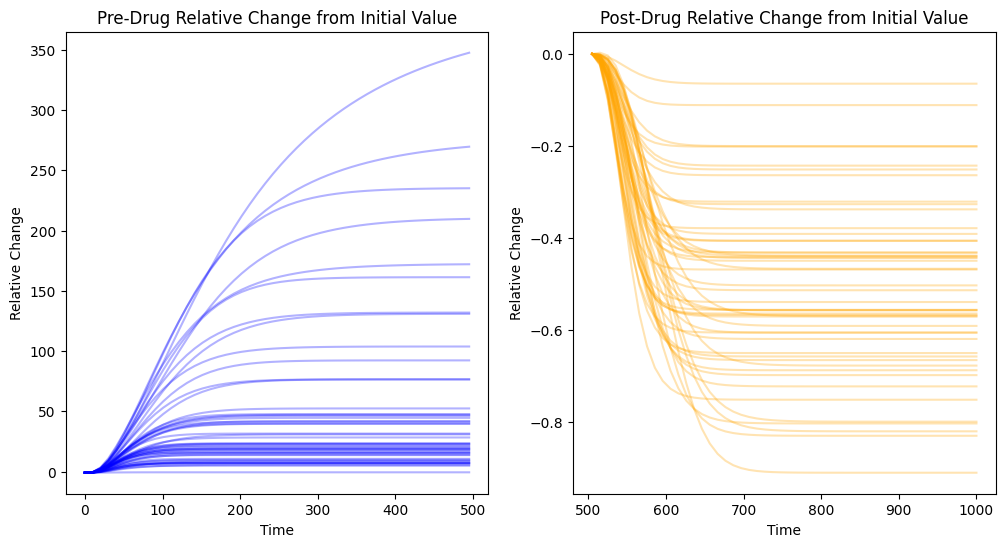

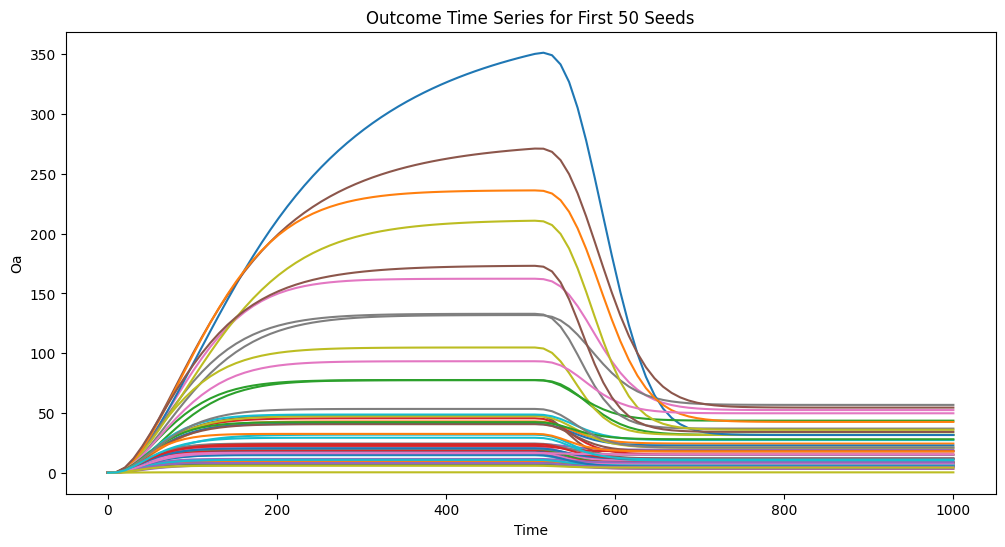

In [10]:
sim_df_specific_seed = []
# for each seed in random_seeds, filter sim_results_df for that seed and append to sim_df_specific_seed
for seed in random_seeds:
    filtered_df = sim_results_df[sim_results_df['seed'] == seed]
    sim_df_specific_seed.append(filtered_df)
    
# then for each dataframe in sim_df_specific_seed, obtain the time series for 'Oa'

outcome_time_series = []
for df in sim_df_specific_seed:
    outcome_time_series.append(df['Oa'].values)
    
# transform the outcome_time_series into two sets: pre-drug and post-drug, time=500 
pre_drug_series = []
post_drug_series = []
drug_time_index = 50
for series in outcome_time_series:
    pre_drug_series.append(series[:drug_time_index])
    post_drug_series.append(series[drug_time_index:])
    

pre_drug_series_relative = []
for pre in pre_drug_series:
    initial_value = pre[0]  # get the first value as initial
    if initial_value == 0:
        initial_value = 1
    pre_relative = (pre - initial_value) / initial_value if initial_value != 0 else np.zeros_like(pre)
    pre_drug_series_relative.append(pre_relative)
    

post_drug_series_relative = []
for post in post_drug_series:
    initial_value = post[0]  # get the first value as initial
    post_relative = (post - initial_value) / initial_value if initial_value != 0 else np.zeros_like(post)
    post_drug_series_relative.append(post_relative)
 
    

# plot the relative pre and post drug series in two subplots
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
for i in range(50):
    plt.plot(
        sim_df_specific_seed[i]["time"].values[:drug_time_index],
        pre_drug_series_relative[i],
        color="blue",
        alpha=0.3,
    )
plt.xlabel("Time")
plt.ylabel("Relative Change")
plt.title("Pre-Drug Relative Change from Initial Value")
plt.subplot(1, 2, 2)
for i in range(50):
    plt.plot(
        sim_df_specific_seed[i]["time"].values[drug_time_index:],
        post_drug_series_relative[i],
        color="orange",
        alpha=0.3,
    )
plt.xlabel("Time")
plt.ylabel("Relative Change")
plt.title("Post-Drug Relative Change from Initial Value")
plt.show()


# plot the outcome_time_series for the first 10 seeds
plt.figure(figsize=(12, 6))
for i in range(50):
    plt.plot(
        sim_df_specific_seed[i]["time"],
        outcome_time_series[i],
        label=f"Seed {random_seeds[i]}",
    )
plt.xlabel("Time")
plt.ylabel("Oa")
plt.title("Outcome Time Series for First 50 Seeds")
# plt.legend()
plt.show()